<a href="https://www.kaggle.com/code/samithsachidanandan/word-embeddings-for-spam-detection?scriptVersionId=282041515" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import argparse
import gensim.downloader as api
import numpy as np
import zipfile
import os
import shutil
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix

2025-11-26 20:02:04.225360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764187324.430309      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764187324.489649      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def download_and_read(url):
  
    zip_path = tf.keras.utils.get_file(
        fname="smsspamcollection.zip",
        origin=url,
        extract=False,  
        cache_dir="."
    )


    extract_dir = os.path.join(os.path.dirname(zip_path), "smsspamcollection")
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

 
    file_path = os.path.join(extract_dir, "SMSSpamCollection")

    labels, texts = [], []

    with open(file_path, "r", encoding="utf-8") as fin:
        for line in fin:
            label, text = line.strip().split('\t')
            labels.append(1 if label == "spam" else 0)
            texts.append(text)

    return texts, labels


DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
texts, labels = download_and_read(DATASET_URL)

  98304/Unknown 0s 4us/step

In [4]:
# tokenize and pad text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(texts)
text_sequences = tokenizer.texts_to_sequences(texts)
text_sequences = tf.keras.preprocessing.sequence.pad_sequences(text_sequences)
num_records = len(text_sequences)
max_seqlen = len(text_sequences[0])
print("{:d} sentences, max length: {:d}".format(num_records, max_seqlen))

5574 sentences, max length: 189


In [5]:
# labels
NUM_CLASSES = 2
cat_labels = tf.keras.utils.to_categorical(
labels, num_classes=NUM_CLASSES)

In [6]:
# vocabulary
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
word2idx["PAD"] = 0
idx2word[0] = "PAD"
vocab_size = len(word2idx)
print("vocab size: {:d}".format(vocab_size))

vocab size: 9010


In [7]:
# dataset
dataset = tf.data.Dataset.from_tensor_slices((text_sequences, cat_labels))
dataset = dataset.shuffle(10000)
test_size = num_records // 4
val_size = (num_records - test_size) // 10
test_dataset = dataset.take(test_size)
val_dataset = dataset.skip(test_size).take(val_size)
train_dataset = dataset.skip(test_size + val_size)
BATCH_SIZE = 128
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

I0000 00:00:1764187337.431155      21 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
import gensim.downloader as api

def build_embedding_matrix(sequences, word2idx, embedding_dim, embedding_file):
    if os.path.exists(embedding_file):
        E = np.load(embedding_file)
        print("Loaded embedding matrix from file.")
    else:
        vocab_size = len(word2idx)
        E = np.zeros((vocab_size, embedding_dim))
        word_vectors = api.load(EMBEDDING_MODEL)  # load GloVe vectors

        for word, idx in word2idx.items():
            try:
                E[idx] = word_vectors[word]
            except KeyError:  # word not in embedding
                pass

        # ensure the directory exists
        os.makedirs(os.path.dirname(embedding_file), exist_ok=True)
        np.save(embedding_file, E)
        print("Saved embedding matrix to file.")

    return E

# Example usage
EMBEDDING_DIM = 300
DATA_DIR = "data"
EMBEDDING_NUMPY_FILE = os.path.join(DATA_DIR, "E.npy")
EMBEDDING_MODEL = "glove-wiki-gigaword-300"

E = build_embedding_matrix(text_sequences, word2idx, EMBEDDING_DIM, EMBEDDING_NUMPY_FILE)
print("Embedding matrix:", E.shape)

[==================================================] 100.0% 376.1/376.1MB downloaded
Saved embedding matrix to file.
Embedding matrix: (9010, 300)


In [9]:
class SpamClassifierModel(tf.keras.Model):
    def __init__(self, vocab_sz, embed_sz, input_length, num_filters, kernel_sz, output_sz, run_mode, embedding_weights=None, **kwargs):
        super(SpamClassifierModel, self).__init__(**kwargs)
        
        if run_mode == "scratch":
            self.embedding = tf.keras.layers.Embedding(
                input_dim=vocab_sz,
                output_dim=embed_sz,
                input_length=input_length,
                trainable=True
            )
        elif run_mode == "vectorizer":
            self.embedding = tf.keras.layers.Embedding(
                input_dim=vocab_sz,
                output_dim=embed_sz,
                input_length=input_length,
                weights=[embedding_weights],
                trainable=False
            )
        else:
            self.embedding = tf.keras.layers.Embedding(
                input_dim=vocab_sz,
                output_dim=embed_sz,
                input_length=input_length,
                weights=[embedding_weights],
                trainable=True
            )
        
        # Increase dropout rates
        self.spatial_dropout = tf.keras.layers.SpatialDropout1D(0.3)  
        
        self.conv = tf.keras.layers.Conv1D(
            filters=num_filters,
            kernel_size=kernel_sz,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001)  
        )
        
        self.pool = tf.keras.layers.GlobalMaxPooling1D()
        
        # Add dropout before dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        
        self.dense = tf.keras.layers.Dense(
            output_sz, 
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(0.001) 
        )
    
    def call(self, x, training=False):
        x = self.embedding(x)
        x = self.spatial_dropout(x, training=training)
        x = self.conv(x)
        x = self.pool(x)
        x = self.dropout(x, training=training)
        x = self.dense(x)
        return x

In [10]:
conv_num_filters = 256
conv_kernel_size = 3
run_mode = "scratch"  # or "vectorizer"
vocab_size = 5000
EMBEDDING_DIM = 100
max_seqlen = 50
NUM_CLASSES = 2
E = None
model = SpamClassifierModel(vocab_size, EMBEDDING_DIM, max_seqlen, conv_num_filters, conv_kernel_size, NUM_CLASSES, run_mode, E)
model.build(input_shape=(None, max_seqlen))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'spam_classifier_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [11]:
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate when plateauing
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Compile with appropriate optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# data distribution is 4827 ham and 747 spam (total 5574), which
# works out to approx 87% ham and 13% spam, so we take reciprocals
# and this works out to being each spam (1) item as being
# approximately 8 times as important as each ham (0) message.
CLASS_WEIGHTS = { 0: 1, 1: 8 }

# Train with callbacks
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


I0000 00:00:1764187518.537600      67 service.cc:148] XLA service 0x7f809000c5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764187518.538170      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764187518.911071      67 cuda_dnn.cc:529] Loaded cuDNN version 90300


22/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4141 - loss: 1.4142

I0000 00:00:1764187521.592409      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.4257 - loss: 1.4028 - val_accuracy: 0.5990 - val_loss: 0.7672 - learning_rate: 0.0010
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7101 - loss: 1.0181 - val_accuracy: 0.9531 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9615 - loss: 0.4639 - val_accuracy: 0.9844 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9709 - loss: 0.3207 - val_accuracy: 0.9844 - val_loss: 0.1744 - learning_rate: 0.0010
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9836 - loss: 0.2493 - val_accuracy: 0.9922 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9873 - loss: 0.2058 - val_accuracy: 0.9922 - val_loss: 0.1373 - learning_rate: 0.0010
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9909 - loss: 0.1586 - val_accuracy: 0.9974 - v

In [12]:

# evaluate against test set
labels, predictions = [], []

for Xtest, Ytest in test_dataset:
    Ytest_ = model.predict_on_batch(Xtest)
    ytest = np.argmax(Ytest, axis=1)
    ytest_ = np.argmax(Ytest_, axis=1)
    labels.extend(ytest.tolist())
    predictions.extend(ytest.tolist())
    print("test accuracy: {:.3f}".format(accuracy_score(labels, predictions)))
    print("confusion matrix")
    print(confusion_matrix(labels, predictions))

test accuracy: 1.000
confusion matrix
[[114   0]
 [  0  14]]
test accuracy: 1.000
confusion matrix
[[225   0]
 [  0  31]]
test accuracy: 1.000
confusion matrix
[[333   0]
 [  0  51]]
test accuracy: 1.000
confusion matrix
[[439   0]
 [  0  73]]
test accuracy: 1.000
confusion matrix
[[552   0]
 [  0  88]]
test accuracy: 1.000
confusion matrix
[[660   0]
 [  0 108]]
test accuracy: 1.000
confusion matrix
[[775   0]
 [  0 121]]
test accuracy: 1.000
confusion matrix
[[887   0]
 [  0 137]]
test accuracy: 1.000
confusion matrix
[[997   0]
 [  0 155]]
test accuracy: 1.000
confusion matrix
[[1110    0]
 [   0  170]]


In [13]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

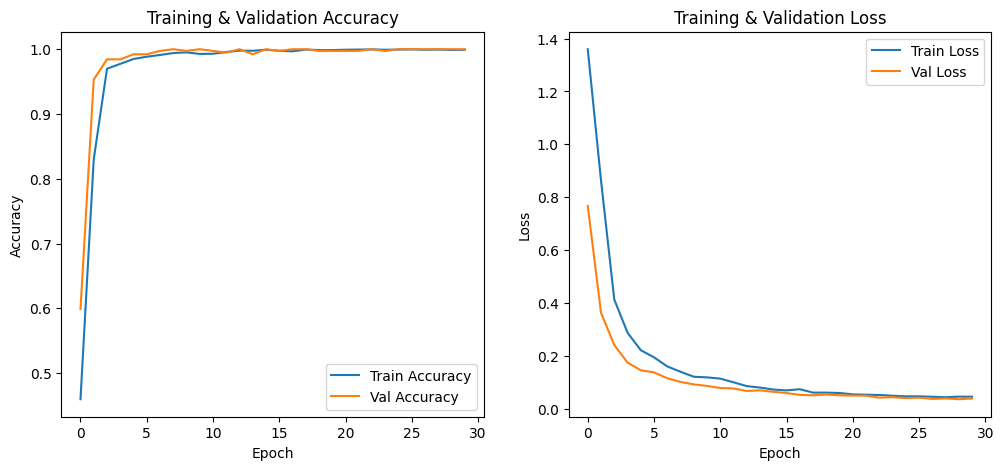

In [14]:
plot_training_history(history)